# EDA

In [28]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
from visualisations import compare_histograms
import random
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor


sns.set_theme(context='notebook', style='darkgrid', palette='tab10')

In [29]:
df = pd.read_csv('../data/clean_combined_wines.csv')
# set name column as index
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino,log_price,age
name,,,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,white,Chardonnay,65.71,0.0,0,13.0,"JS, WE, WS",False,4.185251,7
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,red,Pinot Noir,82.14,0.0,0,12.9,"WE, JS, RP",False,4.408425,5
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,white,Chardonnay,95.28,0.0,0,NaN,"JS, RP, WE",False,4.556820,5
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,red,Pinot Noir,13.96,0.0,0,14.2,WW,False,2.636196,5
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,white,Chardonnay,13.96,0.0,0,14.2,0,False,2.636196,5


In [30]:
print(df.shape)
df.describe()

(49896, 14)


,vintage,price,rating,rating_qty,abv,log_price,age
count,49896.000000,49896.000000,49896.000000,49896.000000,8949.000000,49896.000000,49896.000000
mean,2015.730059,44.211823,3.111496,298.167889,13.639429,3.047707,8.269941
std,3.697926,141.176817,1.585098,751.725910,1.127858,1.010554,3.697926
min,1969.000000,2.080000,0.000000,0.000000,1.200000,0.732368,2.000000
25%,2015.000000,10.000000,3.400000,25.000000,13.000000,2.302585,6.000000
50%,2016.000000,17.840000,3.800000,83.000000,13.800000,2.881442,8.000000
75%,2018.000000,37.260000,4.000000,272.000000,14.500000,3.617920,9.000000
max,2022.000000,8214.650000,5.000000,20293.000000,19.600000,9.013674,55.000000


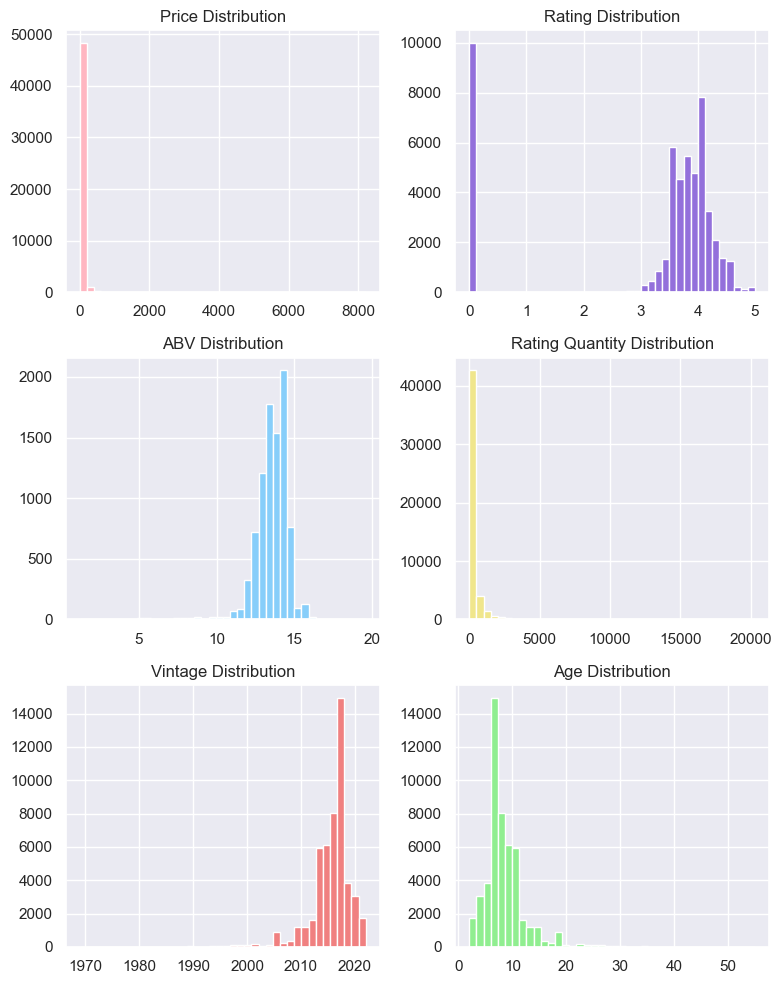

In [31]:

fig, axs = plt.subplots(3, 2, figsize=(8, 10))  
bins = 40
axs[0, 0].hist(df['price'], bins=bins, color='lightpink')
axs[0, 0].set_title('Price Distribution')
axs[0, 0].grid(True)

axs[0, 1].hist(df['rating'], bins=bins, color='mediumpurple')
axs[0, 1].set_title('Rating Distribution')
axs[0, 1].grid(True)

axs[1, 0].hist(df['abv'], bins=bins, color='lightskyblue')
axs[1, 0].set_title('ABV Distribution')
axs[1, 0].grid(True)

axs[1, 1].hist(df['rating_qty'], bins=bins, color='khaki')
axs[1, 1].set_title('Rating Quantity Distribution')
axs[1, 1].grid(True)

axs[2, 0].hist(df['vintage'], bins=bins, color='lightcoral')
axs[2, 0].set_title('Vintage Distribution')
axs[2, 0].grid(True)

axs[2, 1].hist(df['age'], bins=bins, color='lightgreen')
axs[2, 1].set_title('Age Distribution')
axs[2, 1].grid(True)

plt.tight_layout()
# plt.show()


* Prices are heavily right skewed and would likely benefit from a logarithmic transformation before modelling.
* Rating qty also heavily right skewed and would likely benefit from a logarithmic transformation before modelling. Most wine have very few reviews, with some extreme outliers up to 29389. 
* ABV content fairly normally distibuted with clear spike at median of 13.5% 
* High number of observations with zero values in rating and rating_qty which is likely to affect the predictivness of any mode. A wine that has no reviews should not be considered to have a rating of zero. 

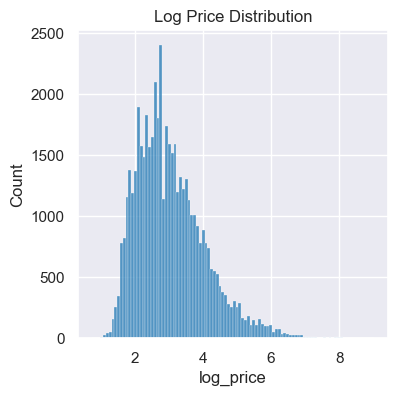

In [32]:
# remove price outliers from dataframe, log transform price and plot

df['log_price'] = np.log(df['price'])
plt.figure(figsize=(4, 4))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 5.591
Number of remaining rows: 48738, rows removed: 1158


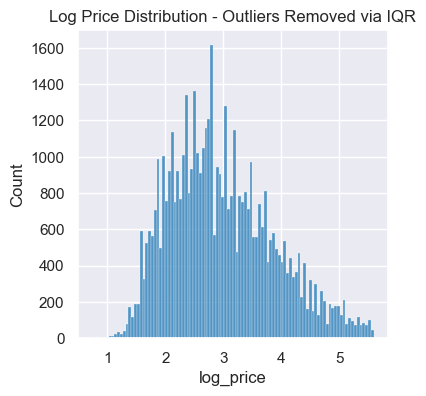

In [33]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(4, 4))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100) 
plt.show();

In [34]:
df['log_price'].describe()

count    49896.000000
mean         3.047707
std          1.010554
min          0.732368
25%          2.302585
50%          2.881442
75%          3.617920
max          9.013674
Name: log_price, dtype: float64

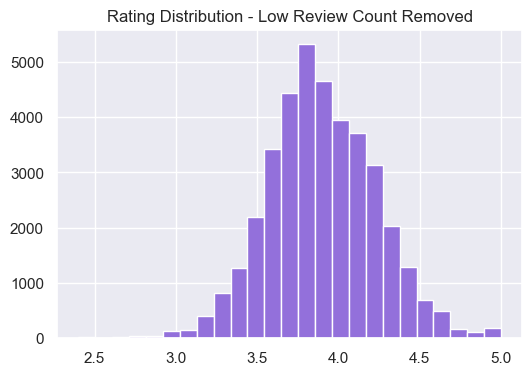

In [35]:
# Filtering out wines with no 10 or fewer reviews
high_rating_qty_only = df[df['rating_qty'] > 10]

plt.figure(figsize=(6, 4))
bins = 25

# Plot for Rating Distribution
plt.hist(high_rating_qty_only['rating'], bins=bins, color='mediumpurple')
plt.title('Rating Distribution - Low Review Count Removed');


In [36]:
high_rating_qty_only['rating'].describe()

count    38566.000000
mean         3.891225
std          0.320886
min          2.400000
25%          3.700000
50%          3.900000
75%          4.100000
max          5.000000
Name: rating, dtype: float64

* Ratings fairly normally distributed around a median of 3.9. Small peak at 5 for wines which have been rated the maximum of 5 stars.

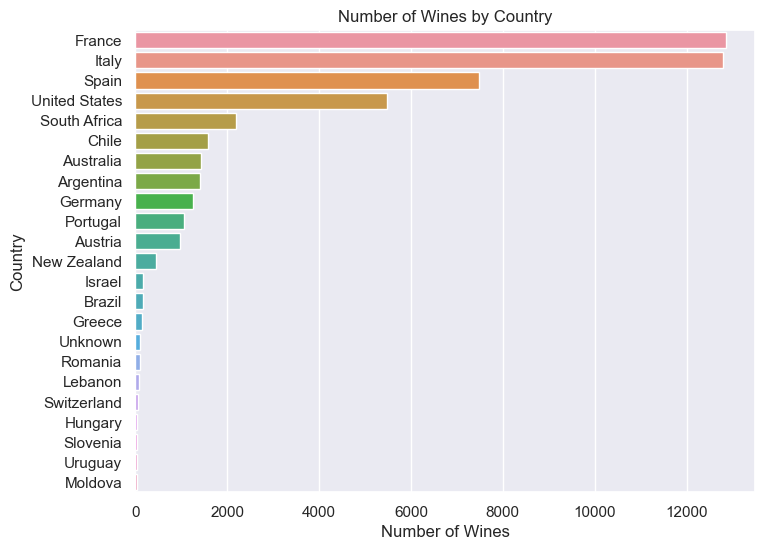

In [37]:
count_wines_by_country = df['country'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=count_wines_by_country.values, y=count_wines_by_country.index)
plt.xlabel('Number of Wines')
plt.ylabel('Country')
plt.title('Number of Wines by Country');

### ABV - Alcohol Content

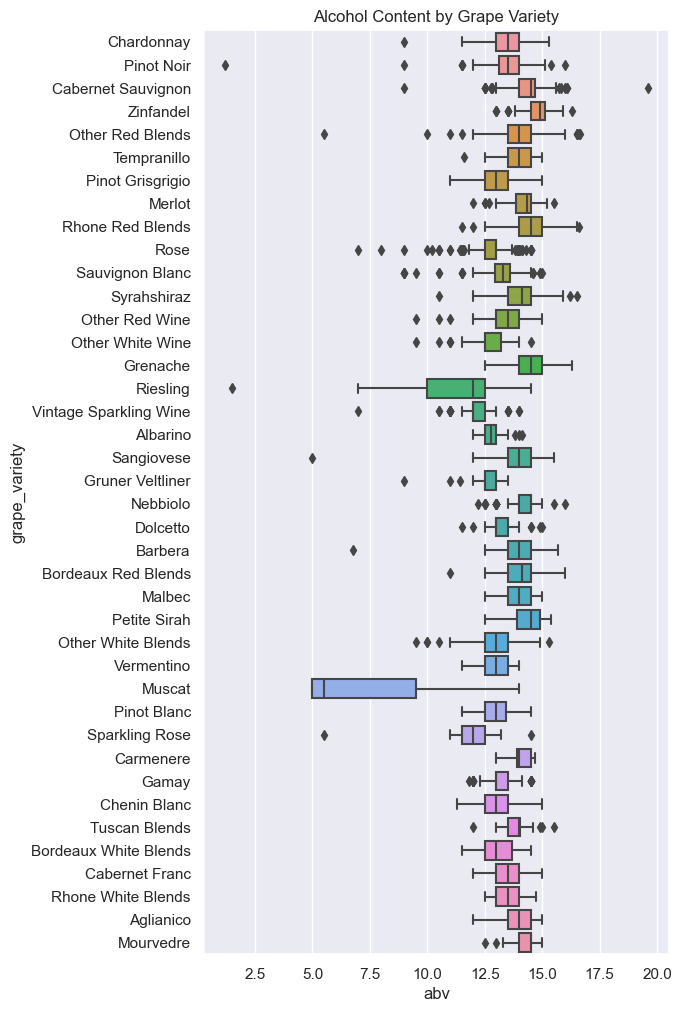

In [38]:
df_a = df[df['abv'].isna() == False]
popular_grape_varieties = df_a[(df_a['grape_variety'].isin((df_a['grape_variety'].value_counts().head(40).index)))]
plt.figure(figsize=(6, 12)) 
sns.boxplot(x='abv', y='grape_variety', data=popular_grape_varieties)
plt.xticks() 
plt.title('Alcohol Content by Grape Variety')
plt.show()


* Fair amount of variation between average abv and abv spread between differing grape varieties. Muscat and Riesling for example are trypically on the lower end of alcohol content.

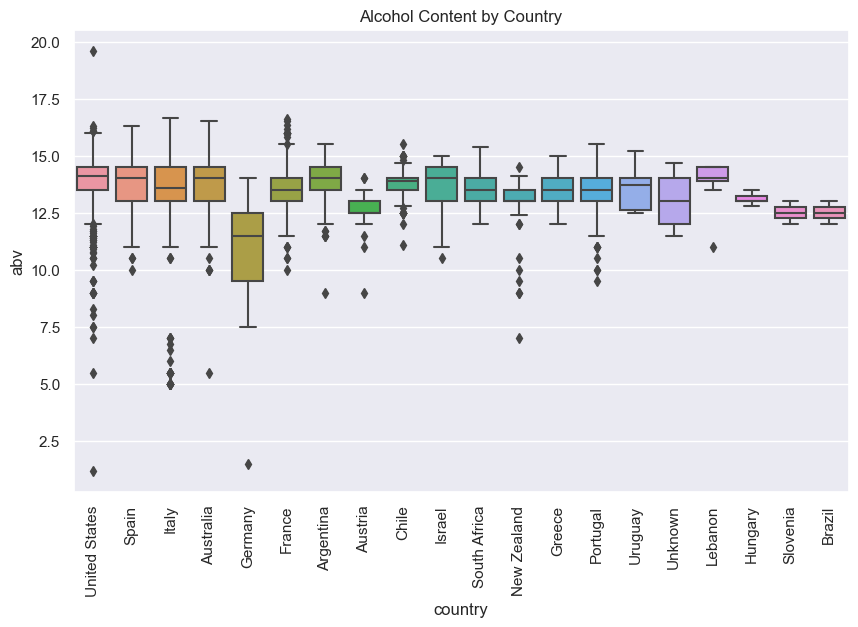

In [39]:
# Box plot for abv 
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='country', y='abv', data=df_a)
plt.xticks(rotation=90) 
plt.title('Alcohol Content by Country')
plt.show()

* Germany, a country known for its Reisling wine is one of the countries with the lowest average alcohol content. 
* Most countries fall between the 15% - 12.5% range 
* Unfortified wines contain anywhere from 5.5% to 16% ABV, with an average in our dataset of 13.6%. 

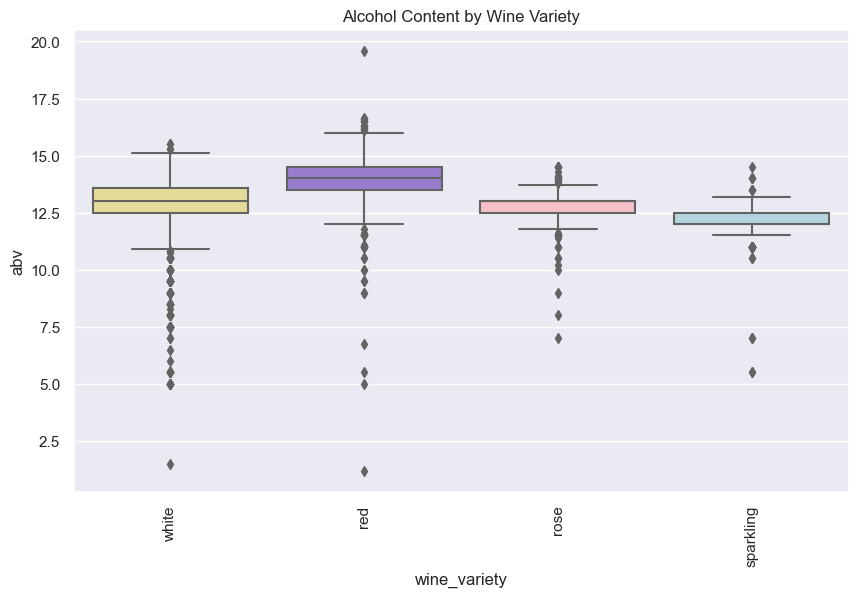

In [40]:
colour_mapping = {
    'red': 'mediumpurple',
    'rose': 'lightpink',
    'white': 'khaki',
    'sparkling': 'lightblue'
}
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='wine_variety', y='abv', data=df_a, palette=colour_mapping)
plt.xticks(rotation=90) 
plt.title('Alcohol Content by Wine Variety')
plt.show()

* Red wines typically have a higher alcohol content than other wine types. 
* Sparkling wines have the lowest. 
* White and rose are in the middle though white has a larger spread than rose overlappying with red and rose wines in abv levels. 

# Correlations

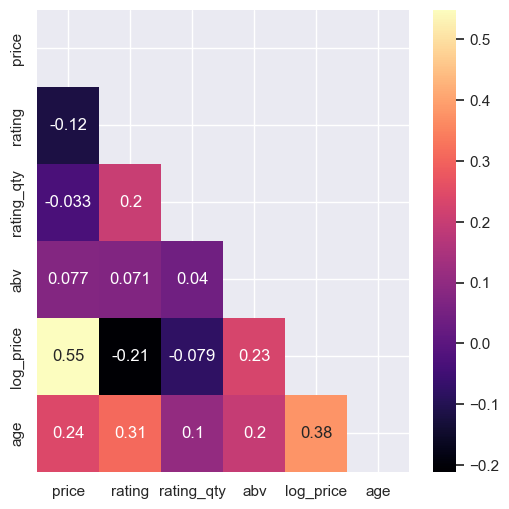

In [41]:
# Correlations on all numeric values - without filtering any data 
numeric = df.drop(columns = [ 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety','reviewed_by','from_vivino'])

plt.figure(figsize=(6, 6))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='magma');

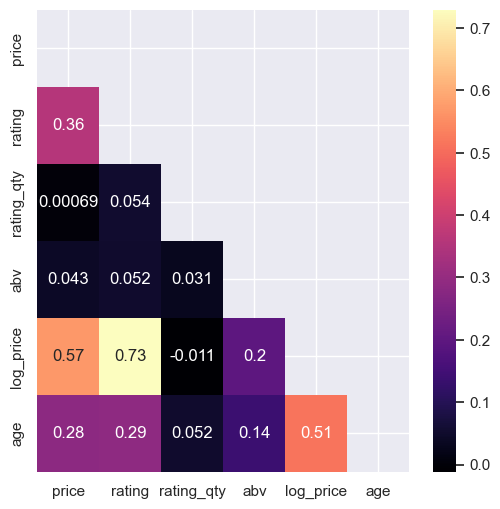

In [42]:
# Filtering data with a minium number of ratings 
numeric = high_rating_qty_only.drop(columns = [ 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety','reviewed_by','from_vivino'])

plt.figure(figsize=(6, 6))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='magma');

* We can see that rating has a high correlation with price when a minimum number of ratings is set. In this case the minimum was 10. 
* Some positive correlation between log_price and alcohol content. 
* Rating and age have a positive correlation, which is to be expected, as wines age they are known to increase in depth of flavour. Furthermore more expensive wines are those created to age better and are often therefore left to age and more likely to be rated more highly once eventually drunk!
* All correlations are stronger with log_price than price suggesting again that our modelling might perform better with log_price as the target. 

In [43]:
# Calculate interquartile range of price and set a limit at 1.5 IQR above 75% percentile for analysis below
Qrt1 = np.quantile(df['price'], 0.25)
Qrt3 = np.quantile(df['price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
outlier_price_limit

78.15

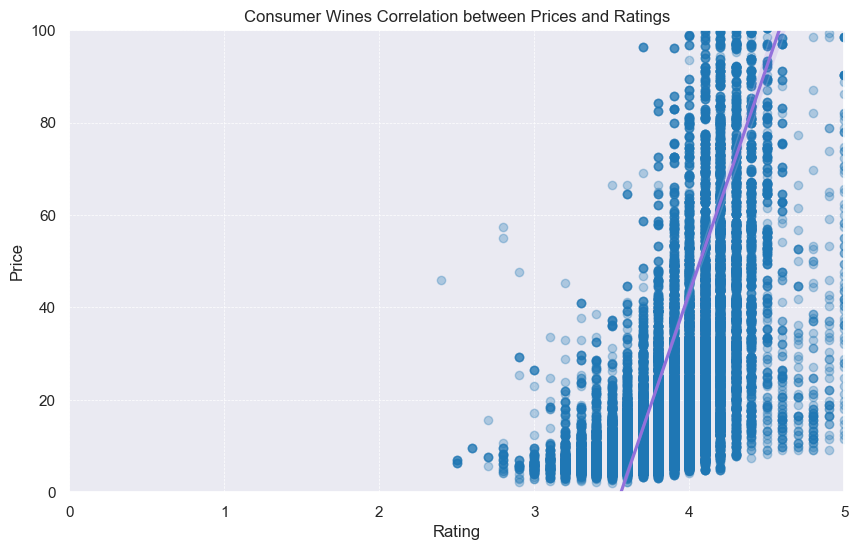

In [44]:
# Focusing only on wines below 78 which is the IQR of price. 
min_rating_qty_consumer_wines = high_rating_qty_only[high_rating_qty_only['price'] < outlier_price_limit]
plt.figure(figsize=(10, 6))
sns.regplot(x='rating', y='price', data=high_rating_qty_only, scatter_kws={'alpha':0.3}, line_kws={'color':'mediumpurple'})
plt.title('Consumer Wines Correlation between Prices and Ratings')
plt.xlabel('Rating')
plt.ylabel('Price')
plt.xlim(0, 5)
plt.ylim(0, 100)
plt.grid(True, which="both", ls="--", linewidth=0.5);

Focusing in on wines below £78.15 and wines with a minimum number of ratings: 
* We can see strong positive correlation between rating and price. 
* No wines with less than an average of 2 star rating. 
* bulk of wines rated around 4. 

# Price

Text(0.5, 1.0, 'Log Price by Wine Variety')

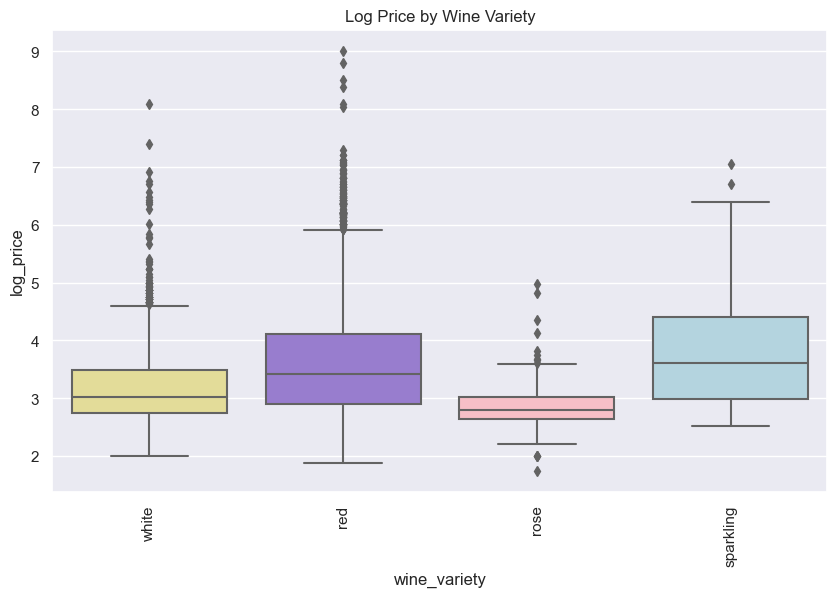

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='wine_variety', y='log_price', data=df_a, palette=colour_mapping)
plt.xticks(rotation=90)
plt.title('Log Price by Wine Variety')

### Producers and Price

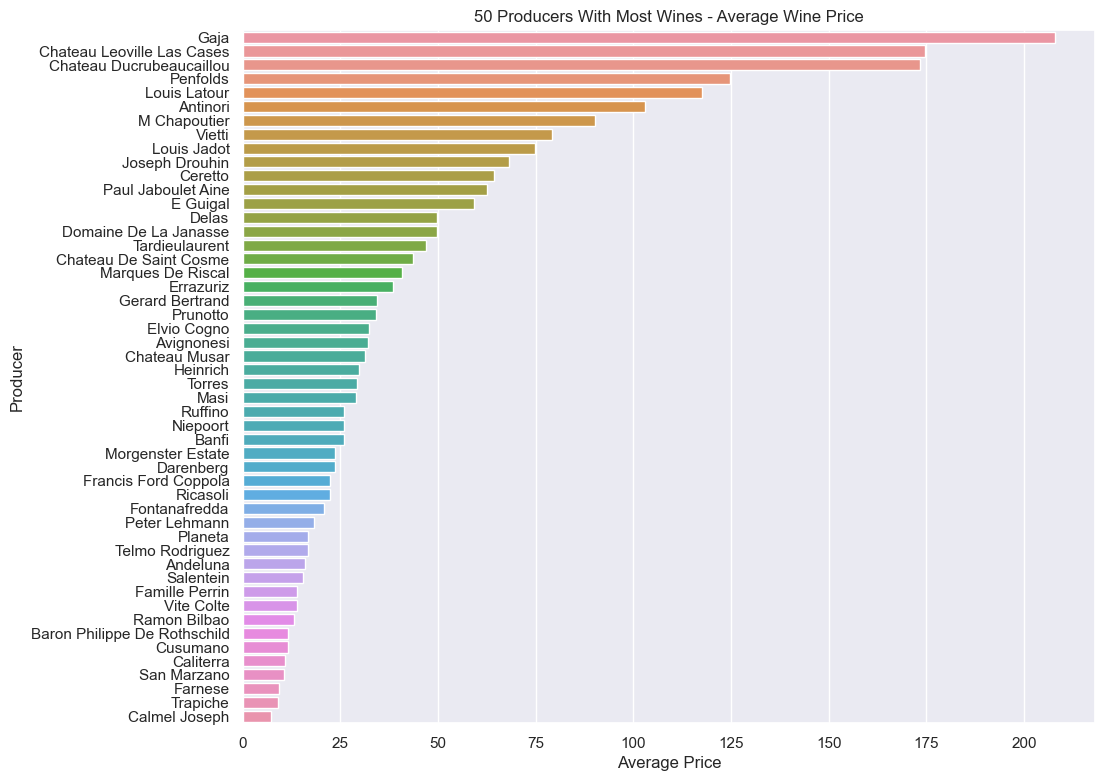

In [46]:
n_producers = 50
top_producers = df['producer'].value_counts().head(n_producers).index
filtered_df = df[df['producer'].isin(top_producers)]
average_prices = filtered_df.groupby('producer')['price'].mean().reset_index()
to_plot = average_prices.sort_values(by='price', ascending=False)

plt.figure(figsize=(11, 9))

sns.barplot(x='price', y='producer', data=to_plot)

plt.xlabel('Average Price')
plt.ylabel('Producer')
plt.title(f'{n_producers} Producers With Most Wines - Average Wine Price');


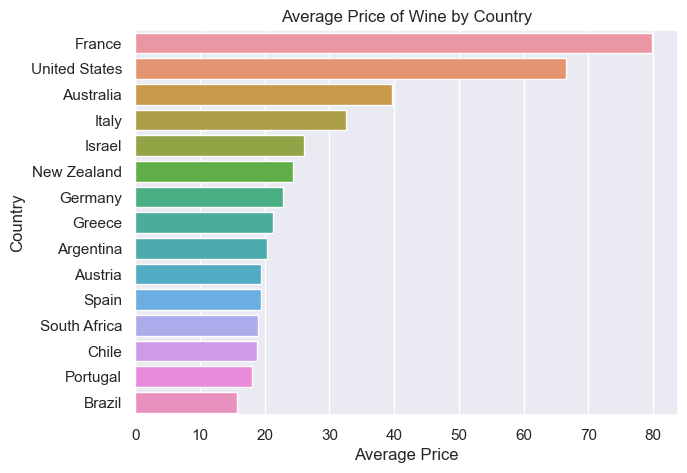

In [47]:
n_countries = 15
countrylist = list(df['country'].value_counts().head(n_countries).index)
top_countries = df[df['country'].isin(countrylist)]
avg_price_by_country = top_countries.groupby('country')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=avg_price_by_country.values, y=avg_price_by_country.index)
plt.xlabel('Average Price')
plt.ylabel('Country')
plt.title('Average Price of Wine by Country');

## Rating

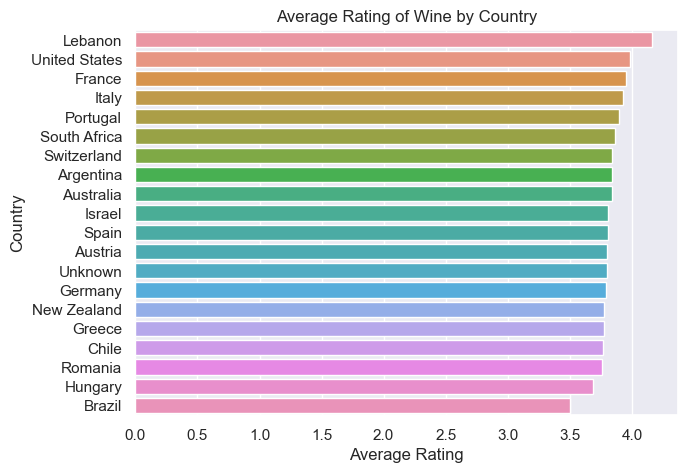

In [48]:
# Average rating by country (using only wines with more than 25 ratings) 
n_countries_r = 20
countrylist = list(df['country'].value_counts().head(n_countries_r).index)
top_countries = high_rating_qty_only[high_rating_qty_only['country'].isin(countrylist)]
avg_rating_by_country = top_countries.groupby('country')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=avg_rating_by_country.values, y=avg_rating_by_country.index)
plt.xlabel('Average Rating')
plt.ylabel('Country')
plt.title('Average Rating of Wine by Country');

In [49]:
high_rating_qty_only['country'].value_counts()

country
Italy            10839
France            9513
Spain             6741
United States     2141
South Africa      2036
Chile             1356
Argentina         1074
Australia         1049
Germany           1005
Portugal           952
Austria            890
New Zealand        295
Brazil             160
Romania             92
Unknown             80
Lebanon             61
Greece              59
Israel              52
Switzerland         48
Hungary             38
Moldova             32
Slovenia            32
Uruguay             21
Name: count, dtype: int64

* Suprising to see wines from lebanon with such high average ratings. There are 60 wines with more than 25 rating_qty from Lebanon in our dataset compared to 9258 from france and 1779 from US, so perhaps this is a sampling quirk. 


# Categoricals

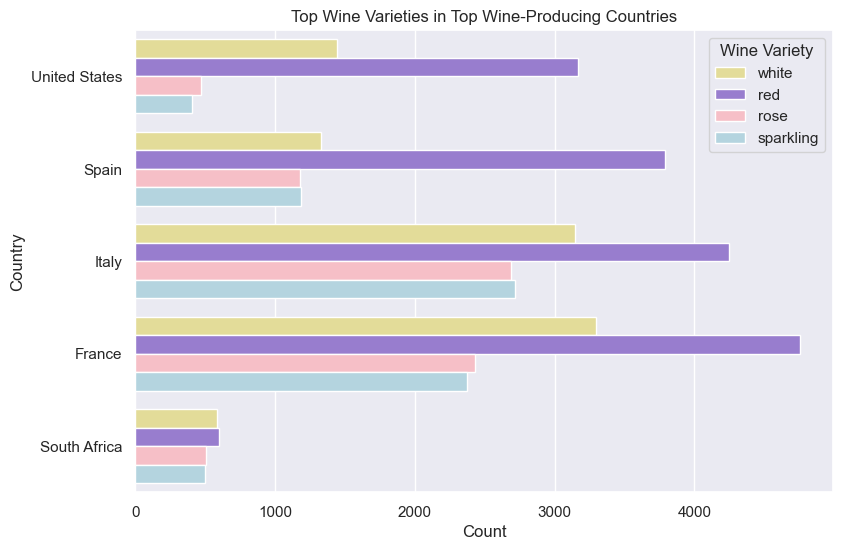

In [50]:
n_countries = 5

colour_mapping = {
    'red': 'mediumpurple',
    'rose': 'lightpink',
    'white': 'khaki',
    'sparkling': 'lightblue'
}

top_countries = df['country'].value_counts().nlargest(n_countries).index
df_top_countries = df[df['country'].isin(top_countries)]

plt.figure(figsize=(9, 6))

sns.countplot(y='country', hue='wine_variety', data=df_top_countries,
              palette=colour_mapping)

plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Top Wine Varieties in Top Wine-Producing Countries')

plt.legend(title='Wine Variety');

* Of the top 5 most appearing countries in our dataset all countries produce red in highest quantity, white is always second and it's close between rose and sparkling.

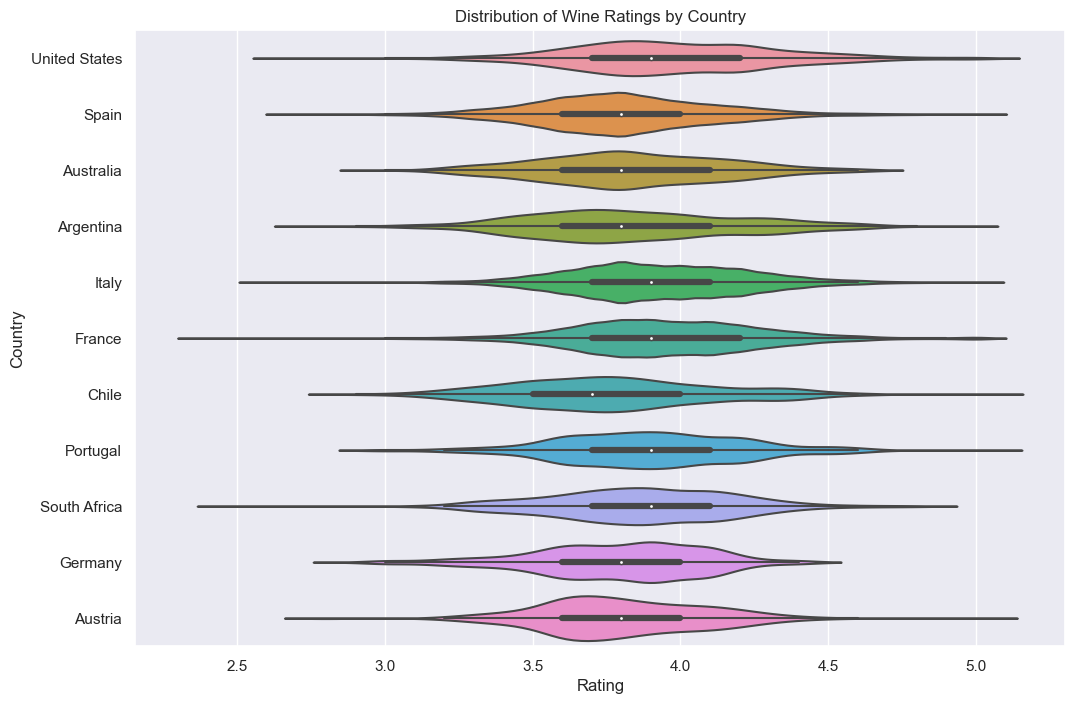

In [51]:
# Filter to include only countries with a significant number of ratings for meaningful comparison
significant_countries = high_rating_qty_only.groupby('country').filter(lambda x: len(x) > 500)

plt.figure(figsize=(12, 8))
sns.violinplot(x='rating', y='country', data=significant_countries)
plt.xlabel('Rating')
plt.ylabel('Country')
plt.title('Distribution of Wine Ratings by Country');

# EDA Functions For Application

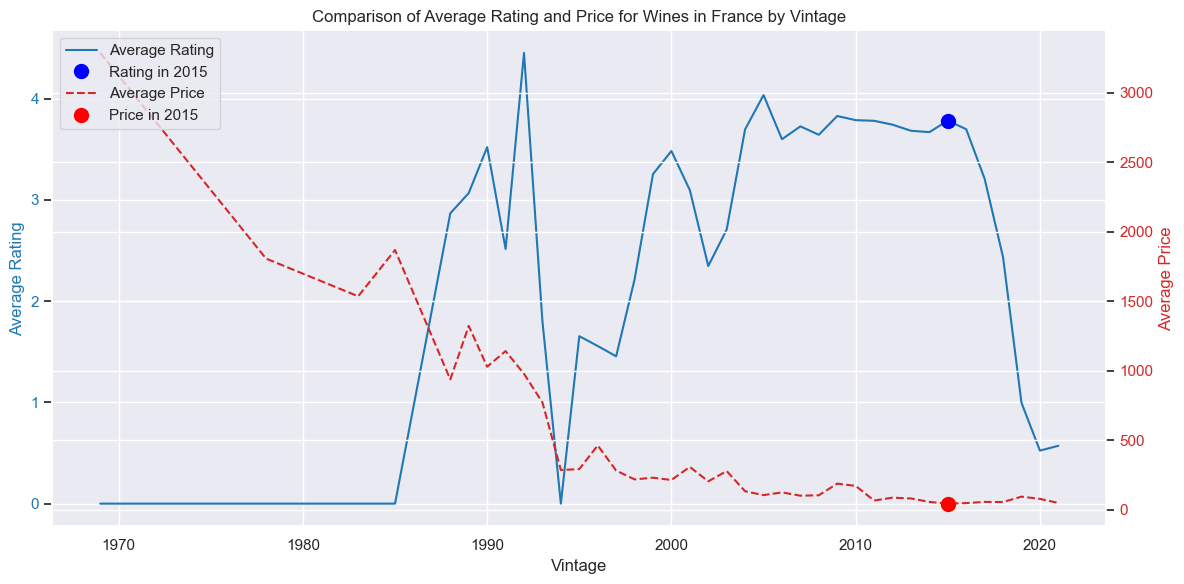

In [52]:
def plot_country_vintage_comparison(df, country, vintage):
    # Filter data for the selected country
    country_data = df[df['country'] == country]
    
    # Calculate average rating and price by vintage for the country
    avg_metrics = country_data.groupby('vintage')[['rating', 'price']].mean().reset_index()
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot average rating
    color = 'tab:blue'
    ax1.set_xlabel('Vintage')
    ax1.set_ylabel('Average Rating', color=color)
    ax1.plot(avg_metrics['vintage'], avg_metrics['rating'], color=color, label='Average Rating')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Highlight the selected vintage for rating
    specific_vintage_rating = avg_metrics[avg_metrics['vintage'] == vintage]['rating']
    ax1.plot(vintage, specific_vintage_rating, 'bo', markersize=10, label=f'Rating in {vintage}')
    
    # Create a twin axis for average price
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Price', color=color)
    ax2.plot(avg_metrics['vintage'], avg_metrics['price'], color=color, linestyle='--', label='Average Price')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Highlight the selected vintage for price
    specific_vintage_price = avg_metrics[avg_metrics['vintage'] == vintage]['price']
    ax2.plot(vintage, specific_vintage_price, 'ro', markersize=10, label=f'Price in {vintage}')

    # Final touches
    ax1.set_title(f'Comparison of Average Rating and Price for Wines in {country} by Vintage')
    fig.tight_layout()
    
    # Legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()

# Example usage
plot_country_vintage_comparison(df, 'France', 2015)


In [53]:
def compare_close_vintages_in_country(df, country, vintage):
    # Filter the DataFrame for the selected country
    country_df = df[df['country'] == country]
    
    # Ensure there are at least 3 representations in the data for the vintage
    vintage_counts = country_df.groupby('vintage').filter(lambda x: len(x) >= 3)
    
    # Group by vintage and calculate average rating and price for vintages with >= 3 representations
    avg_metrics_by_vintage = vintage_counts.groupby('vintage')[['rating', 'price']].mean().reset_index()
    
    # Find the specified vintage's position
    vintage_position = avg_metrics_by_vintage[avg_metrics_by_vintage['vintage'] == vintage].index
    
    # Check if specified vintage exists in the filtered DataFrame
    if not vintage_position.empty:
        position = vintage_position[0]
        
        # Calculate the start and end positions to include 3 vintages before and after
        start_pos = max(0, position - 3)
        end_pos = min(len(avg_metrics_by_vintage), position + 4)  # +1 because slicing is exclusive
        
        # Select the 6 closest vintages
        closest_vintages = avg_metrics_by_vintage.iloc[start_pos:end_pos]
        
        print(f"Closest vintages to {vintage} in {country} with at least 3 representations:")
        print(closest_vintages)
    else:
        print(f"No data available for {country} in {vintage} or doesn't meet the representation criteria.")

# Example usage
compare_close_vintages_in_country(df, 'France', 2015)


Closest vintages to 2015 in France with at least 3 representations:
    vintage    rating      price
24     2012  3.741723  88.297891
25     2013  3.681839  82.398879
26     2014  3.668046  57.612958
27     2015  3.781622  45.285304
28     2016  3.697036  49.338171
29     2017  3.207111  57.513981
30     2018  2.432776  56.712922
